# Inaugural Project 

$\textbf{Team OLM}$

Members: Mads Janell, Oliver Bøgedal Jensen and Ludvig Scott Poulsen

Firstly, we import the relevant packages.

In [69]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt # baseline modul
from mpl_toolkits.mplot3d import Axes3D # for 3d figures
from matplotlib import cm # for colormaps
plt.style.use('seaborn-whitegrid')

# Question 1

The task is to solve the household’s problem. Therefore, we begin by setting the parameter values in a dictionary and defining the utility function. We include the contraints in the utility function. By doing so, we can use the optimizer function without bounds.

In [49]:
#Setting the parameters
par = {'phi': 0.3, 'epsilon': 0.5, 'r': 0.03, 'tg': 0.012, 'tp': 0.004, 'pbar': 3, 'm':0.5}

#Defining the utility funtction
def u(h,par):
    u = ((par['m']-(par['r']*h+par['tg']*h*par['epsilon']+par['tp']*max((h*par['epsilon'])-par['pbar'],0)))**(1-par['phi'])*h**par['phi'])
    return u

Now we maximize with respect to $\textit{h}$. 

In [50]:
# Maximizing by using scalar optimiser function
def u_optimiser(par):
    def objective(h,par):
        return -u(h, par)

    sol = optimize.minimize_scalar(objective,args=(par))

    h_star = sol.x
    c_star = par['m']-(par['r']*h_star+par['tg']*h_star*par['epsilon']+par['tp']*max((h_star*par['epsilon'])-par['pbar'],0))
    u_star = u(h_star, par)
    return h_star, c_star, u_star

h_star, c_star, u_star = u_optimiser(par)

#Printing the optimal values and the resulting utility
print(f'At the given parameters the household will choose an optimal quality of housing at {h_star:.3f}, which implies optimal consumption = {c_star:.3f} and utility = {u_star:.3f}.')


At the given parameters the household will choose an optimal quality of housing at 4.167, which implies optimal consumption = 0.350 and utility = 0.736.


# Question 2


We will now plot $\textit{h}^*$ and $\textit{c}^*$ as a function of m in the range of 0.4 to 2.5.

In [51]:
# Allocating array for solution: 
N = 1000
m_vec = np.linspace(0.4,1.5,N)
h_vec = np.zeros(N)
c_vec = np.zeros(N)

# Looping the optimiser over the m array
for i, m in enumerate(m_vec): 
    par.update({'m':m})
    h_vec[i] = u_optimiser(par)[0]
    c_vec[i] = m_vec[i]-(par['r']*h_vec[i]+par['tg']*h_vec[i]*par['epsilon']+par['tp']*max((h_vec[i]*par['epsilon'])-par['pbar'],0))

Plot the results.

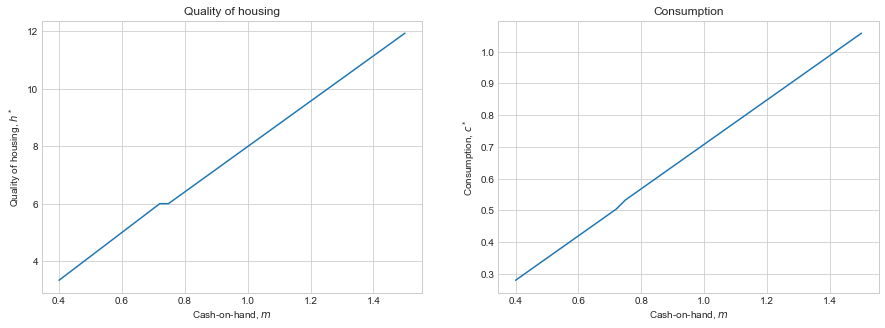

In [52]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1,2,1)
ax.plot(m_vec,h_vec,'-')
ax.set_ylabel('Quality of housing, $h^*$')
ax.set_xlabel('Cash-on-hand, $m$')
ax.set_title('Quality of housing')

ax = fig.add_subplot(1,2,2)
ax.plot(m_vec,c_vec,'-')
ax.set_ylabel('Consumption, $c^*$')
ax.set_xlabel('Cash-on-hand, $m$')
ax.set_title('Consumption');

As expected we see a small kink at $\textit{h}^*=6$. This is the point where the progressive housing tax kicks in.

# Question 3

In this section we will calculate the average tax burden pr household.

In [53]:
# Setting parameter values
seed = 1 
size = 10000
mu, sigma = -0.4, 0.35 

In [62]:
def tax_revenue(seed,size,mu,sigma,epsilon,tp,tg,pbar):
    
    # Setting seed and drawing random numbers
    np.random.seed(seed)
    mi = np.random.lognormal(mu,sigma,size)
    
    
    # Defining local parameter values
    phi = 0.3
    r = 0.03

    # Solving each individual's optimisation problem
    tax_rev = 0

    for i, mi in enumerate (mi):
        par.update({'m':mi})
        hc = u_optimiser(par)
        tax_i = tg*hc[0]*epsilon + tp*max(hc[0]*epsilon-pbar,0)
        tax_rev += tax_i

    return tax_rev

total_tax_rev = tax_revenue(seed,size,mu,sigma,epsilon=0.5,tp=0.004,tg=0.012,pbar=3)

# Printing the total tax revenu
print(f'The total tax revenue is {total_tax_rev:.2f}.')

The total tax revenue is 363.27.


In [55]:
# Average tax burden pr. household 
tax_burden = total_tax_rev/size

print(f'Average tax burden pr. household is {tax_burden:.3f}.')

Average tax burden pr. household is 0.036.


# Question 4

To answer this question, we simply run the function from question 3 with the updated parameter values.

In [65]:
total_tax_rev = tax_revenue(seed,size,mu,sigma,epsilon=0.8,tg=0.01,tp=0.009,pbar=8)
print(f'The total tax revenue is {total_tax_rev:.2f}.')

The total tax revenue is 470.67.


In [64]:
tax_burden = total_tax_rev/size
print(f'Average tax burden pr. household is {tax_burden:.3f}.')

Average tax burden pr. household is 0.047.


# Question 5

In [58]:
total_tax_rev = tax_revenue(seed,size,mu,sigma,epsilon=0.8,tg=0.00772,tp=0.009,pbar=8)
print(f'The total tax revenue is {total_tax_rev:.2f}')

The total tax revenue is 364.36


In [67]:
tax_revenue_goal = 363.27

# e. find equilibrium function
def find_equilibrium(epsilon,tp,tg,pbar,kappa=0.5,eps=1e-8,maxiter=50): #sæt egne værdier ind før kappa
    
    t = 0
    while True:

        # a. step 1: excess tax
        Z1 = tax_revenue(seed,size,mu,sigma,epsilon,tp,tg,pbar) - tax_revenue_goal
        
        # b: step 2: stop?
        if  np.abs(Z1) < eps or t >= maxiter:
            print(f'{t:3d}: tg = {tg:12.8f} -> excess tax -> {Z1:14.8f}')
            break    
    
        # c. step 3: update p1
        tg = tg - tg*kappa*Z1/tax_revenue_goal
            
        # d. step 4: return 
        if t < 6 or t%5 == 0:
            print(f'{t:3d}: tg = {tg:12.8f} -> excess tax -> {Z1:14.8f}')
        elif t == 5:
            print('   ...')
            
        t += 1    

    return tg

# e. call find equilibrium function
epsilon = 0.8
tg = 0.5
tp = 0.009
pbar = 8
kappa = 0.5
eps = 1e-8
tg = find_equilibrium(epsilon,tg,tp,pbar,kappa=kappa,eps=eps)

  0: tg =   0.00527831 -> excess tax ->   300.43978441
  1: tg =   0.00435635 -> excess tax ->   126.90485328
  2: tg =   0.00385319 -> excess tax ->    83.91559799
  3: tg =   0.00353257 -> excess tax ->    60.45430544
  4: tg =   0.00331132 -> excess tax ->    45.50454751
  5: tg =   0.00315094 -> excess tax ->    35.18804943
 10: tg =   0.00276393 -> excess tax ->    11.79039078
 15: tg =   0.00263661 -> excess tax ->     4.49296401
 20: tg =   0.00258858 -> excess tax ->     1.78587531
 25: tg =   0.00256958 -> excess tax ->     0.72123674
 30: tg =   0.00256191 -> excess tax ->     0.29311560
 35: tg =   0.00255880 -> excess tax ->     0.11942697
 40: tg =   0.00255753 -> excess tax ->     0.04870949
 45: tg =   0.00255702 -> excess tax ->     0.01987500
 50: tg =   0.00255684 -> excess tax ->     0.00811101


We are aware that this answer is not correct, and that there are faults in our code. We have tried to solve it, but were unsuccessful. Any help would be greatly appreciated.

# Conclusion

In this assignment we used our newly acquired coding skills to solve a consumer utility maximisation problem. At the preliminary paramete values, a household with cash-on-hand *m*=5 will purchase a house at 4.167 mil. Furthermore, we visualized our results by plotting them in question 2.

In question 3 and 4 we considered the whole population and found the average tax burden pr household at different parameter values. Lastly we tried to find the new *$\tau^g$*, which met the requirements of the policy maker.